In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import skew, kurtosis, entropy, iqr
from scipy.fft import fft, fftfreq
from scipy.signal import welch, find_peaks
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
from IPython.display import display, HTML

# === Part 1: Feature Engineering ===

# Suppress matplotlib warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

#  Configuration 
folder_path = "./harth"  
sensor_column = 'back_x' # to calculate time domain features on
sampling_interval = 0.02  # 50 Hz

In [2]:
# Data Aggregation, Preprocessing 
all_sensor_values = []
all_timestamps = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            if sensor_column not in df.columns or 'timestamp' not in df.columns:
                continue
            timestamps = pd.to_datetime(df['timestamp'], errors='coerce')
            sensor_data = df[sensor_column]
            valid = timestamps.notna() & sensor_data.notna()
            timestamps = timestamps[valid].to_numpy()
            sensor_data = sensor_data[valid].to_numpy()
            if len(sensor_data) < 2:
                continue
            all_sensor_values.extend(sensor_data)
            all_timestamps.extend(timestamps)
        except:
            continue

# Convert to NumPy array 
x = np.array(all_sensor_values)
N = len(x)

In [3]:
# Time-Domain Features 
features = {
    'Mean': np.mean(x),
    'Standard Deviation': np.std(x),
    'Variance': np.var(x),
    'Min': np.min(x),
    'Max': np.max(x),
    'Range': np.ptp(x),
    'Median': np.median(x),
    'IQR': iqr(x),
    'RMS': np.sqrt(np.mean(x**2)),
    'Zero-Crossing Rate': ((x[:-1] * x[1:]) < 0).sum(),
    'Skewness': skew(x),
    'Kurtosis': kurtosis(x),
    'Energy': np.sum(x**2),
    'Autocorrelation (lag 1)': np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan,
    'Peak Count': len(find_peaks(x)[0]),
    'Peak Amplitude': np.max(x[find_peaks(x)[0]]) if len(find_peaks(x)[0]) > 0 else np.nan,
}

# Frequency-Domain Features 
yf = fft(x)
xf = fftfreq(N, sampling_interval)[:N // 2]
amplitudes = 2.0 / N * np.abs(yf[0:N // 2])

features.update({
    'Spectral Centroid': np.sum(xf * amplitudes) / np.sum(amplitudes),
    'Spectral Energy': np.sum(amplitudes**2),
    'Spectral Entropy': entropy(amplitudes / np.sum(amplitudes)),
    'Frequency Variance': np.var(amplitudes),
    'Spectral Flatness': np.exp(np.mean(np.log(amplitudes + 1e-10))) / np.mean(amplitudes),
    'Peak Frequency': xf[np.argmax(amplitudes)],
    'Bandwidth': np.max(xf) - np.min(xf),
    'FFT Coefficients': amplitudes[:10].tolist(),  # First 10 FFT values
})

#  PSD (Power Spectral Density) 
f_psd, psd_values = welch(x, fs=1/sampling_interval)
features.update({
    'PSD Mean': np.mean(psd_values),
    'PSD Max': np.max(psd_values)
})

Mean,Standard Deviation,Variance,Min,Max,Range,Median,IQR,RMS,Zero-Crossing Rate,Skewness,Kurtosis,Energy,Autocorrelation (lag 1),Peak Count,Peak Amplitude,Spectral Centroid,Spectral Energy,Spectral Entropy,Frequency Variance,Spectral Flatness,Peak Frequency,Bandwidth,FFT Coefficients,PSD Mean,PSD Max
-0.884957,0.377592,0.142575,-8.0,2.291708,10.291708,-0.9749,0.190089,0.962146,48067,-0.248229,11.190133,5.981413e+06,0.876447,1986705,2.291708,8.549441,3.41775,14.418685,0.000001,0.654063,0.0,24.999992,"1.7699, 0.0225, 0.0471, 0.0128, 0.0154, 0.0252, 0.0186, 0.0282, 0.0350, 0.0272",0.003164,0.106129


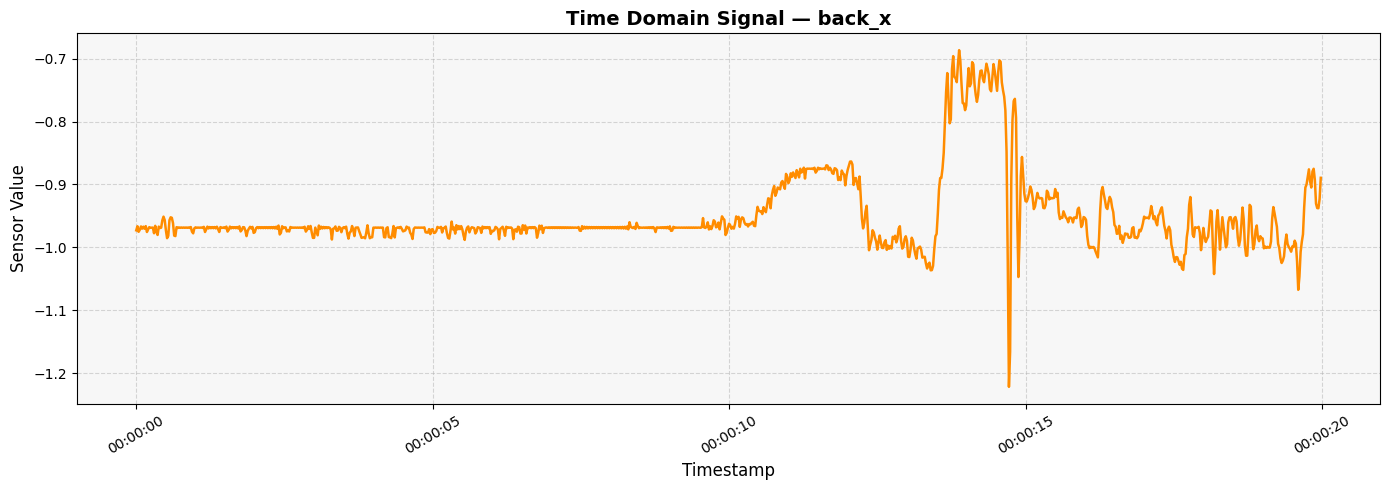

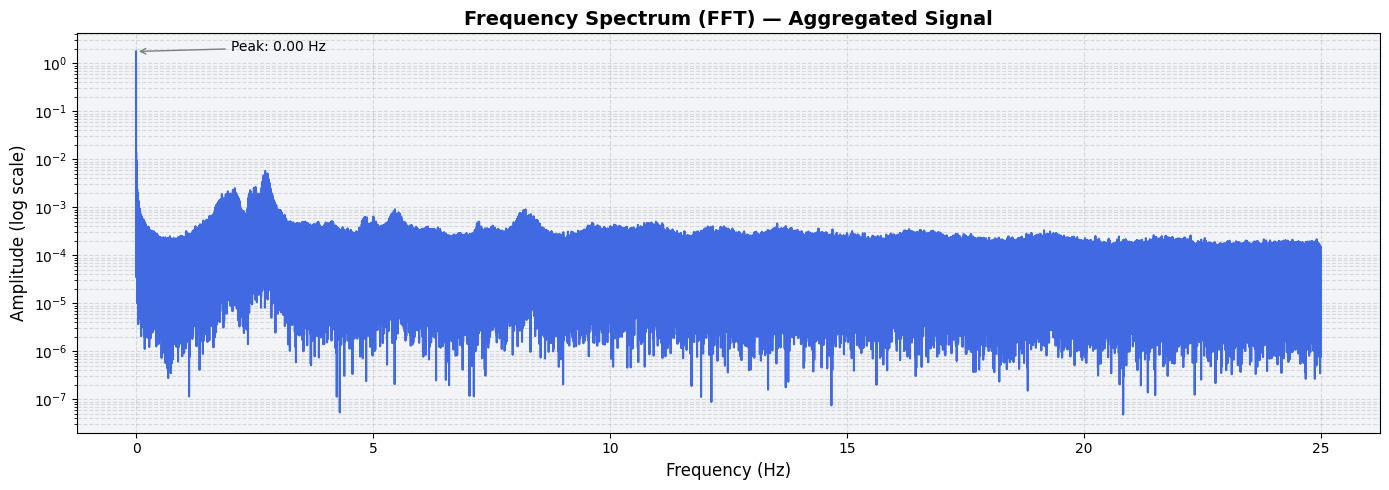

In [4]:
# --- Format FFT Coefficients into a single-line string ---
features['FFT Coefficients'] = ', '.join(f'{val:.4f}' for val in features['FFT Coefficients'])

# --- Create and display DataFrame without index and ellipsis ---
features_df = pd.DataFrame([features])
html_output = features_df.to_html(index=False, max_cols=None, escape=False)
display(HTML(f"<div style='overflow-x:auto'>{html_output}</div>"))

# --- Time Domain Plot ---
plt.figure(figsize=(14, 5))
plt.plot(all_timestamps[:1000], x[:1000], color='darkorange', linewidth=1.8)
plt.gca().set_facecolor('#f7f7f7')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=30)
plt.title(f"Time Domain Signal — {sensor_column}", fontsize=14, fontweight='bold')
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Frequency Domain Plot ---
plt.figure(figsize=(14, 5))
plt.plot(xf, amplitudes, color='royalblue', linewidth=1.5)
plt.gca().set_facecolor('#f2f4f8')
plt.yscale('log')
plt.title("Frequency Spectrum (FFT) — Aggregated Signal", fontsize=14, fontweight='bold')
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (log scale)", fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.4)

# Annotate peak frequency
peak_amp = np.max(amplitudes)
peak_index = np.argmax(amplitudes)
plt.annotate(f"Peak: {xf[peak_index]:.2f} Hz", 
             xy=(xf[peak_index], peak_amp), 
             xytext=(xf[peak_index]+2, peak_amp),
             arrowprops=dict(arrowstyle="->", color='gray'), 
             fontsize=10, color='black')
plt.tight_layout()
plt.show()